# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm as tq
from torch.utils.data import DataLoader, Dataset
from random import shuffle
# from torchviz import make_dot
from itertools import combinations


from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN, Birch, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from transformers import AutoTokenizer, BertModel

# Dataset

Dataset for of MAnhwa Comics come from:

- [Kaggle](https://www.kaggle.com/datasets/iridazzle/webtoon-originals-datasets?select=webtoon_originals_en.csv)

In [ ]:
# @title Datset Loading Options {"vertical-output":true,"display-mode":"form"}
opt_init = "Connect to drive and use saved dataframe" # @param ["Connect to drive and use saved dataframe","Use dtaframe uploaded to current runtime"]


opt_init_d = {
    "Connect to drive and use saved dataframe": 0,
    "Use dtaframe uploaded to current runtime": 1
}

In [ ]:
if opt_init_d[opt_init] == 0:
  path = input("Enter Custom (complete) Path or 0 to use default path: eg-/content/drive/MyDrive/folder_name/subfolder_name/filename.csv")
  if int(path) == 0:
    path = '/content/drive/MyDrive/Manhwa Data/manhwa_mal.csv'
  from google.colab import drive
  drive.mount('/content/drive')
  try:
    data = pd.read_csv(path)
  except:
    print("Something Went Wrong with the path information! Try the following:\n 1. Check if the drive is connected or not.\n 2. Check if given path and file exists in drive.\n 3. Reconnect and re-run the cells.\n")
else:
  file_name = input("Enter the filename: eg-filename.csv")
  try: data = pd.read_csv(f'/content/{file_name}')
  except: print(f"Something went wrong! Try the following:\n 1. Check if the given file-{file_name} exits in the correct path and current runtime.\n 2. Check if the file was properly uploaded.\n 3. Delete runtime, reconnect and try again.\n")

Enter Custom (complete) Path or 0 to use default path: eg-/content/drive/MyDrive/folder_name/subfolder_name/filename.csv0
Mounted at /content/drive


In [ ]:
data.head()

,Unnamed: 0,type,title,chapters,status,genres,favorites,popularity,rank,score,members,synopsis,volumns,authors,publish_time
0,0,manhwa,Solo Leveling,201,Finished,"Action,Adventure,Fantasy","40,014",#7,#56,8.68,"431,289","Ten years ago, ""the Gate"" appeared and connect...",Unknown,"Chugong (Story), Jang, Sung-rak (Art), Discipl...","Mar 4, 2018 to May 31, 2023"
1,1,manhwa,The Horizon,21,Finished,"Adventure,Drama","4,047",#187,#58,8.67,"75,806","In a world ravaged by war, a young boy walks d...",3,"Jeong, Ji-Hoon (Story & Art)","Mar 30, 2016 to Jul 21, 2016"
2,2,manhwa,Wind Breaker,Unknown,Publishing,"Action,Drama,Sports","2,688",#368,#94,8.58,"42,434","Burdened with expectations since childhood, se...",Unknown,"Jo, Yongseok (Story & Art)","Dec 15, 2013 to ?"
3,3,manhwa,Bastard,94,Finished,"Drama,Horror,Mystery,Romance","6,455",#84,#140,8.50,"126,088",There is nowhere that Seon Jin can find solace...,5,"Kim, Carnby (Story), Hwang, Young-chan (Art)","Jul 4, 2014 to May 6, 2016"
4,4,manhwa,Who Made Me a Princess,125,Finished,"Comedy,Fantasy,Romance","2,648",#349,#175,8.44,"44,428","In the novel The Lovely Princess, the secondar...",9,"Plutus (Story), Spoon (Art)","Dec 20, 2017 to Apr 30, 2022"


# Preprocessing

In [ ]:
data['synopsis'].describe()

,synopsis
count,2789
unique,2690
top,An anthology of horror short stories by variou...
freq,4


1. Cleaning 'Nan' Values for synopsis

In [ ]:
data_cleaned = data.dropna(subset=['synopsis'])

>

In [ ]:
(data.shape, data_cleaned.shape)

((2943, 15), (2789, 15))

2. Dropping Duplicates

In [ ]:
data_no_duplicates = data_cleaned.drop_duplicates(subset=['title'])
data_cleaned.shape[0] - data_no_duplicates.shape[0]

101

# BERT

Using BERT tokenizer and model to generate Vector Embeddings for Synopsis

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Preparing Data for with BERT

### Using Averaged token vector for sentence representation.

In [ ]:
def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state.mean(dim=1).squeeze().tolist()

In [ ]:
data_no_duplicates['synopsis_embeddings'] = data_no_duplicates['synopsis'].apply(get_embedding)

<ipython-input-15-4f3ff5fbd724>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_duplicates['synopsis_embeddings'] = data_no_duplicates['synopsis'].apply(get_embedding)


In [ ]:
df_avg = data_no_duplicates[['title', 'synopsis_embeddings']]
df_avg.head()

,title,synopsis_embeddings
0,Solo Leveling,"[-0.25960567593574524, 0.02596401982009411, 0...."
1,The Horizon,"[-0.017733626067638397, -0.09611794352531433, ..."
2,Wind Breaker,"[-0.2808888256549835, -0.00941705796867609, 0...."
3,Bastard,"[-0.26607832312583923, -0.027077075093984604, ..."
4,Who Made Me a Princess,"[-0.31436124444007874, -0.09806779772043228, 0..."


# PCA

In [ ]:
# @title Setting number of PCA components {"vertical-output":true,"display-mode":"form"}
pca_comps = 128 # @param {"type":"integer","placeholder":"128"}

In [ ]:
pca = PCA(n_components=pca_comps)
pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
print(type(pca_embedd))
print(pca_embedd.shape)

# Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

# Create a list of tensors, each with shape (1, 64)
pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

# Create a new column in the DataFrame and assign the list of tensors
df_avg['pca_embeddings'] = [i for i in pca_embedd]

df_avg.head()

<class 'numpy.ndarray'>
(2688, 128)


<ipython-input-28-3508a868768e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_avg['pca_embeddings'] = [i for i in pca_embedd]


,title,synopsis_embeddings,pca_embeddings,cluster
0,Solo Leveling,"[-0.25960567593574524, 0.02596401982009411, 0....","[0.7897685868897457, 1.3083193122504908, 0.886...",0
1,The Horizon,"[-0.017733626067638397, -0.09611794352531433, ...","[0.3208514381049948, 0.8387122447936255, -0.78...",24
2,Wind Breaker,"[-0.2808888256549835, -0.00941705796867609, 0....","[-0.5367380990146179, 1.375307894300401, 0.213...",198
3,Bastard,"[-0.26607832312583923, -0.027077075093984604, ...","[-0.0802474765061111, 1.5858524366379914, -0.3...",198
4,Who Made Me a Princess,"[-0.31436124444007874, -0.09806779772043228, 0...","[1.2068851485167067, 1.3281795419728968, -0.92...",24


# Save DataFrames

> Save the Dataframes generated above to skip processing

In [ ]:
# @title Save Pickle File {"vertical-output":true,"display-mode":"form"}
# @markdown Do you want to save the above generated Dataframe?
save_choice = "Yes" # @param ["Yes","No"]


In [ ]:
# @title Save options {"vertical-output":true,"display-mode":"form"}
# @markdown Select a save Option:
opt = "Connect to google drive and save" # @param ["Connect to google drive and save to custom path","Connect to google drive and save","Save to runtime memory"]


opt_d = {
    "Connect to google drive and save to custom path": 0,
    "Connect to google drive and save": 1,
    "Save to runtime memory": 2
}

In [ ]:
if save_choice == "Yes" and opt_d[opt] == 0 :
  path = input("Enter Custom (complete) Path: ")
  try: pd.to_pickle(df_avg, f'{path}/df_avg_{pca_comps}.pkl')
  except: print("df_avg dataframe Dosen't Exist! Try: \n 1. Make sure you're google drive is connected to the runtime and the save path exists.\n 2. Re-run above cells to generate the processed dataframe\n 3.Disconnecting and then reconnecting to a runtime and running above cells\n 4. Loading a previously saved Dataframe from below given cells")

elif save_choice == "Yes" and opt_d[opt] == 1 :
  try: pd.to_pickle(df_avg, f'/content/drive/MyDrive/Manhwa Data/df_avg_{pca_comps}.pkl')
  except: print("df_avg dataframe Dosen't Exist! Try: \n 1. Make sure you're google drive is connected to the runtime and the save path exists.\n 2. Re-run above cells to generate the processed dataframe\n 3.Disconnecting and then reconnecting to a runtime and running above cells\n 4. Loading a previously saved Dataframe from below given cells")

elif save_choice == "Yes" and opt_d[opt] == 2:
  pd.to_pickle(df_avg, f'/content/df_avg_{pca_comps}.pkl')

NameError: name 'save_choice' is not defined

# Load Processed Datasets

In [ ]:
# @title Load Pickle File {"display-mode":"form"}
# @markdown Do you want to load a Dataframe?
load_choice = "Yes" # @param ["Yes","No"]


In [ ]:
# @title Load Parameters {"vertical-output":true,"display-mode":"form"}
path = "/content/drive/MyDrive/Manhwa Data" # @param {"type":"string","placeholder":"/absolute/path/to/file"}
filename = "df_avg.pkl" # @param {"type":"string","placeholder":"file_name.pkl"}



In [ ]:
if load_choice == "Yes":
  try: df_avg = pd.read_pickle(f'{path}/{filename}')
  except: print(f"{filename} dataframe Dosen't Exist! Try: \n 1. Make sure you're google drive is connected to the runtime and the load path exists.\n 2. Check if the dataset exists in drive/path\n 3.Disconnecting and then reconnecting to a runtime and running above cells")

In [ ]:
type(df_avg['synopsis_embeddings'].iloc[0])

list

# Models

**Info on Clustering Models:**


---

<table class="table">
<colgroup>
<col style="width: 15.1%">
<col style="width: 16.1%">
<col style="width: 20.4%">
<col style="width: 26.9%">
<col style="width: 21.5%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Method name</p></th>
<th class="head"><p>Parameters</p></th>
<th class="head"><p>Scalability</p></th>
<th class="head"><p>Usecase</p></th>
<th class="head"><p>Geometry (metric used)</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><a class="reference internal" href="#k-means"><span class="std std-ref">K-Means</span></a></p></td>
<td><p>number of clusters</p></td>
<td><p>Very large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, medium <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code> with
<a class="reference internal" href="#mini-batch-kmeans"><span class="std std-ref">MiniBatch code</span></a></p></td>
<td><p>General-purpose, even cluster size, flat geometry,
not too many clusters, inductive</p></td>
<td><p>Distances between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#affinity-propagation"><span class="std std-ref">Affinity propagation</span></a></p></td>
<td><p>damping, sample preference</p></td>
<td><p>Not scalable with n_samples</p></td>
<td><p>Many clusters, uneven cluster size, non-flat geometry, inductive</p></td>
<td><p>Graph distance (e.g. nearest-neighbor graph)</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#mean-shift"><span class="std std-ref">Mean-shift</span></a></p></td>
<td><p>bandwidth</p></td>
<td><p>Not scalable with <code class="docutils literal notranslate"><span class="pre">n_samples</span></code></p></td>
<td><p>Many clusters, uneven cluster size, non-flat geometry, inductive</p></td>
<td><p>Distances between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#spectral-clustering"><span class="std std-ref">Spectral clustering</span></a></p></td>
<td><p>number of clusters</p></td>
<td><p>Medium <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, small <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Few clusters, even cluster size, non-flat geometry, transductive</p></td>
<td><p>Graph distance (e.g. nearest-neighbor graph)</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#hierarchical-clustering"><span class="std std-ref">Ward hierarchical clustering</span></a></p></td>
<td><p>number of clusters or distance threshold</p></td>
<td><p>Large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code> and <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Many clusters, possibly connectivity constraints, transductive</p></td>
<td><p>Distances between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#hierarchical-clustering"><span class="std std-ref">Agglomerative clustering</span></a></p></td>
<td><p>number of clusters or distance threshold, linkage type, distance</p></td>
<td><p>Large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code> and <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Many clusters, possibly connectivity constraints, non Euclidean
distances, transductive</p></td>
<td><p>Any pairwise distance</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#dbscan"><span class="std std-ref">DBSCAN</span></a></p></td>
<td><p>neighborhood size</p></td>
<td><p>Very large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, medium <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Non-flat geometry, uneven cluster sizes, outlier removal,
transductive</p></td>
<td><p>Distances between nearest points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#hdbscan"><span class="std std-ref">HDBSCAN</span></a></p></td>
<td><p>minimum cluster membership, minimum point neighbors</p></td>
<td><p>large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, medium <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Non-flat geometry, uneven cluster sizes, outlier removal,
transductive, hierarchical, variable cluster density</p></td>
<td><p>Distances between nearest points</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#optics"><span class="std std-ref">OPTICS</span></a></p></td>
<td><p>minimum cluster membership</p></td>
<td><p>Very large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, large <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>Non-flat geometry, uneven cluster sizes, variable cluster density,
outlier removal, transductive</p></td>
<td><p>Distances between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="mixture.html#mixture"><span class="std std-ref">Gaussian mixtures</span></a></p></td>
<td><p>many</p></td>
<td><p>Not scalable</p></td>
<td><p>Flat geometry, good for density estimation, inductive</p></td>
<td><p>Mahalanobis distances to  centers</p></td>
</tr>
<tr class="row-even"><td><p><a class="reference internal" href="#birch"><span class="std std-ref">BIRCH</span></a></p></td>
<td><p>branching factor, threshold, optional global clusterer.</p></td>
<td><p>Large <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code> and <code class="docutils literal notranslate"><span class="pre">n_samples</span></code></p></td>
<td><p>Large dataset, outlier removal, data reduction, inductive</p></td>
<td><p>Euclidean distance between points</p></td>
</tr>
<tr class="row-odd"><td><p><a class="reference internal" href="#bisect-k-means"><span class="std std-ref">Bisecting K-Means</span></a></p></td>
<td><p>number of clusters</p></td>
<td><p>Very large <code class="docutils literal notranslate"><span class="pre">n_samples</span></code>, medium <code class="docutils literal notranslate"><span class="pre">n_clusters</span></code></p></td>
<td><p>General-purpose, even cluster size, flat geometry,
no empty clusters, inductive, hierarchical</p></td>
<td><p>Distances between points</p></td>
</tr>
</tbody>
</table>

---

Source: [Scikit Learn Documentaion](https://scikit-learn.org/stable/modules/clustering#affinity-propagation)

In [ ]:
# @title Set Parameters {"vertical-output":true,"display-mode":"form"}
# @markdown Select the upper limit of PCA range (Selecting 140 on the slider indicates trying all pca options from 0 to 140 at a step rate of 16):


# @markdown **NOTE** - PCA with value `0` or `pca_comp == 0` indicates no PCA happening. essentially, take all features as is.

pca_comps = 256 # @param {"type":"slider","min":0,"max":256,"step":16}



# @markdown Set the number of clusters for the models.
num_clusters = 423 # @param {"type":"slider","min":3,"max":423,"step":20}

losses = []
n_clusters = [int(i) for i in np.linspace(3, num_clusters, num=10)]

pca_range = [i for i in range(0, pca_comps+1, 16)]

## Silhouette Scores

To calculate the Silhouette Score for a dataset, you can follow the following steps:

**Calculate average distance**

For each data point
$i$
, calculate the following values:

$a_i$
: The average distance of
$i$
 to all other data points in the same cluster (intra-cluster distance)

$b_i$
: The average distance of
$i$
 to all data points in the nearest cluster (inter-cluster distance)




---



**Calculate Silhouette Score for each point**

Calculate the Silhouette Score for each data point. The Silhouette Score for each data point
$i$
 is calculated as follows:

$
Silhouette Score = \frac{max(a_i, b_i)}{b_i - a_i}\
$



---


**Calculate the overall Silhouette Score**

Calculate the overall Silhouette Score for the clustering result by averaging the individual Silhouette Score of all the points.

$
Silhoutte Score = \frac{\sum_{i = 1}^{n} Silhouette Score (i)}{n}
$



---



Source: [Educative.io](https://www.educative.io/answers/what-is-silhouette-score)

### 1. Affinity Propagation


---

This style of model was chosen for its usecase properties. This model also helps in generating a good estimate of number of clusters for other models.

In [ ]:
affP = AffinityPropagation()
losses = []
n_clusters = []

for i in pca_range:
  if i == 0:
    df_avg['cluster'] = affP.fit_predict(df_avg['synopsis_embeddings'].tolist())

  else:
    pca = PCA(n_components=i)
    pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
    # Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
    pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

    # Create a list of tensors, each with shape (1, 64)
    pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

    # Create a new column in the DataFrame and assign the list of tensors
    df_avg['pca_embeddings'] = [i for i in pca_embedd]

    df_avg['cluster'] = affP.fit_predict(df_avg['pca_embeddings'].tolist())

  losses = losses + [silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]
  n_clusters = n_clusters + [len(affP.cluster_centers_)]

print(len(losses), losses[0], "\n", len(pca_range), pca_range[0], "\n", len(n_clusters), n_clusters[0])

data = {'Number of Clusters': n_clusters, 'PCA Components': pca_range, 'Silhouette Loss': losses}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


17 0.0004013220049181865 
 17 0 
 17 216


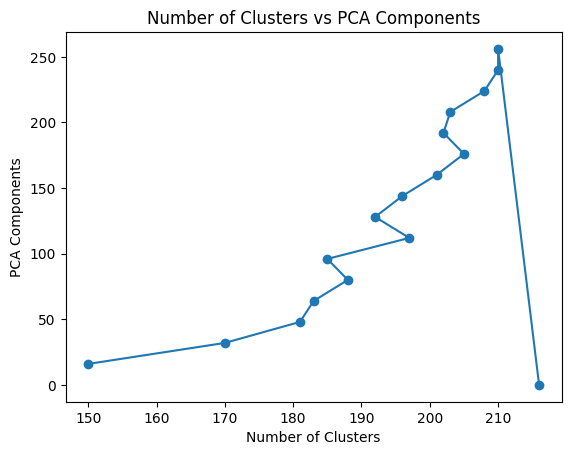

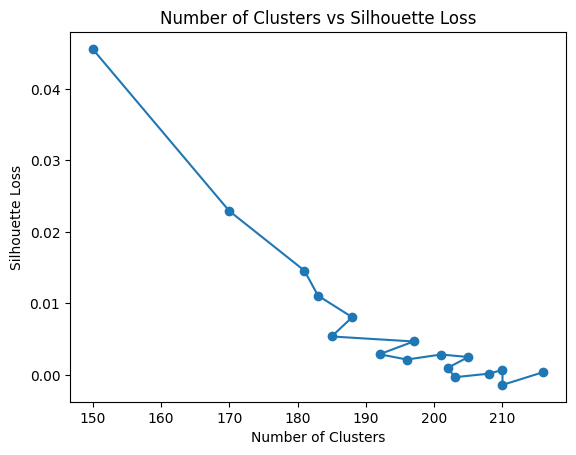

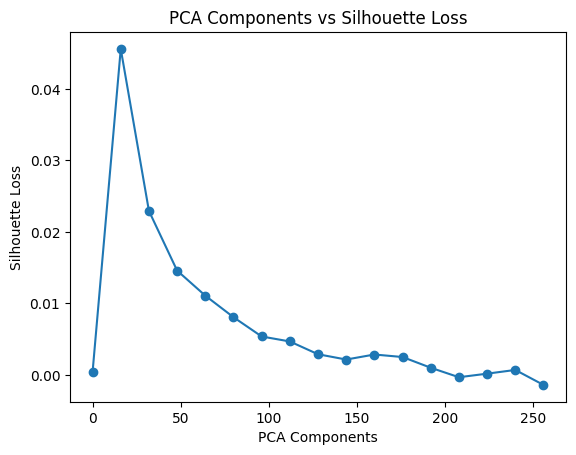

In [ ]:
# plt.subplot(1, 3, 1)
plt.plot(data['Number of Clusters'][1:] + [data['Number of Clusters'][0]], data['PCA Components'][1:] + [data['PCA Components'][0]], marker='o')
plt.title('Number of Clusters vs PCA Components')
plt.xlabel('Number of Clusters')
plt.ylabel('PCA Components')
plt.show()

# plt.subplot(1, 3, 2)
plt.plot(data['Number of Clusters'][1:] + [data['Number of Clusters'][0]], data['Silhouette Loss'][1:] + [data['Silhouette Loss'][0]], marker='o')
plt.title('Number of Clusters vs Silhouette Loss')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Loss')
plt.show()

# plt.subplot(1, 3, 3)
plt.plot(data['PCA Components'], data['Silhouette Loss'], marker='o')
plt.title('PCA Components vs Silhouette Loss')
plt.xlabel('PCA Components')
plt.ylabel('Silhouette Loss')
plt.show()

### 2. KMeans


---

Kmeans was chosen as it is useful for multiple use cases and provides a baseline performance to measure other algorithms.

In [ ]:
losses = []
if len(n_clusters) == 0:
  n_clusters = [int(i) for i in np.linspace(3, num_clusters, num=10)]


for j in n_clusters:
  kmeans = KMeans(n_clusters=j, random_state=42)
  temp_loss = []
  for i in pca_range:
    if i == 0:
      df_avg['cluster'] = kmeans.fit_predict(df_avg['synopsis_embeddings'].tolist())

    else:
      pca = PCA(n_components=i)
      pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
      # Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
      pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

      # Create a list of tensors, each with shape (1, 64)
      pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

      # Create a new column in the DataFrame and assign the list of tensors
      df_avg['pca_embeddings'] = [i for i in pca_embedd]

      df_avg['cluster'] = kmeans.fit_predict(df_avg['pca_embeddings'].tolist())

    temp_loss = temp_loss + [silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]

  losses.append(temp_loss)



print(len(losses), losses[0], "\n", len(pca_range), pca_range[0], "\n", len(n_clusters), n_clusters[0])

data = {'Number of Clusters': n_clusters, 'PCA Components': pca_range, 'Silhouette Loss': losses}

10 [0.07492839070391294, 0.1342013064298778, 0.10478091508260932, 0.0919084833805375, 0.08519410381573847, 0.08069852202777689, 0.07692938918624469, 0.07501872661040128, 0.07251945590823976, 0.07105754725026732, 0.06997714962801874, 0.06872386562581807, 0.06779898395145467, 0.0668887694597042, 0.06630157232865101, 0.06559454321235898, 0.06506420581913058] 
 17 0 
 10 3


In [ ]:
colors = cm.tab10(np.linspace(0, 1, len(n_clusters)))
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]])

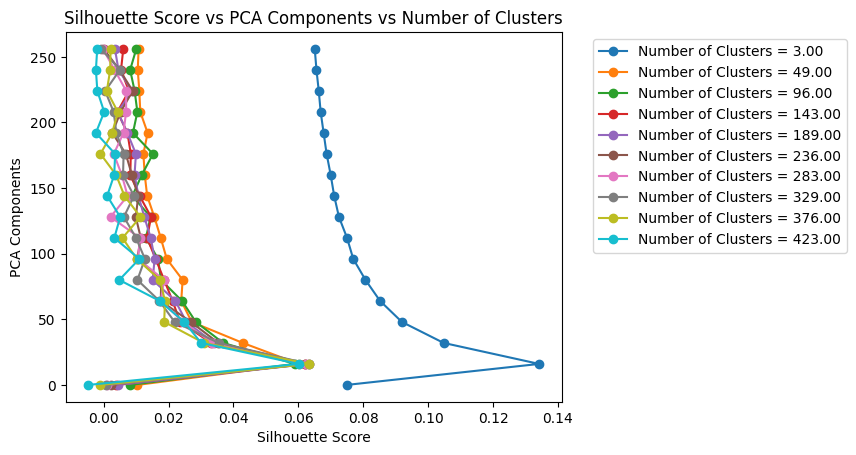

In [ ]:
for i in range(len(n_clusters)):
    plt.plot(losses[i], pca_range, label=f'Number of Clusters = {n_clusters[i]:.2f}', color=colors[i], marker='o')

# Add labels and legend
plt.xlabel('Silhouette Score')
plt.ylabel('PCA Components')
plt.title('Silhouette Score vs PCA Components vs Number of Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

plt.show()

### 3. Agglomerative Clustering with Ward Linkage


---

Supports both large number of samples with large number of clusters.

In [ ]:
losses = []
if len(n_clusters) == 0:
  n_clusters = [int(i) for i in np.linspace(3, num_clusters, num=10)]


for j in n_clusters:
  agg_w = AgglomerativeClustering(n_clusters=j, linkage='ward')
  temp_loss = []
  for i in pca_range:
    if i == 0:
      df_avg['cluster'] = kmeans.fit_predict(df_avg['synopsis_embeddings'].tolist())

    else:
      pca = PCA(n_components=i)
      pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
      # Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
      pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

      # Create a list of tensors, each with shape (1, 64)
      pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

      # Create a new column in the DataFrame and assign the list of tensors
      df_avg['pca_embeddings'] = [i for i in pca_embedd]

      df_avg['cluster'] = agg_w.fit_predict(df_avg['pca_embeddings'].tolist())

    temp_loss = temp_loss + [silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]

  losses.append(temp_loss)



print(len(losses), losses[0], "\n", len(pca_range), pca_range[0], "\n", len(n_clusters), n_clusters[0])

data = {'Number of Clusters': n_clusters, 'PCA Components': pca_range, 'Silhouette Loss': losses}

10 [-0.0046410903904249, 0.08507698685965608, 0.08454586404559121, 0.056426032664634786, 0.06139186627524714, 0.04720182898711077, 0.054273438755064685, 0.03805897229316183, 0.05471739745215866, 0.042695698908445386, 0.06569847235115957, 0.05816278711278001, 0.054486241024884995, 0.049302365810128264, 0.058112287187306384, 0.03556235128553207, 0.041677983676218784] 
 17 0 
 10 3


In [ ]:
colors = cm.tab10(np.linspace(0, 1, len(n_clusters)))

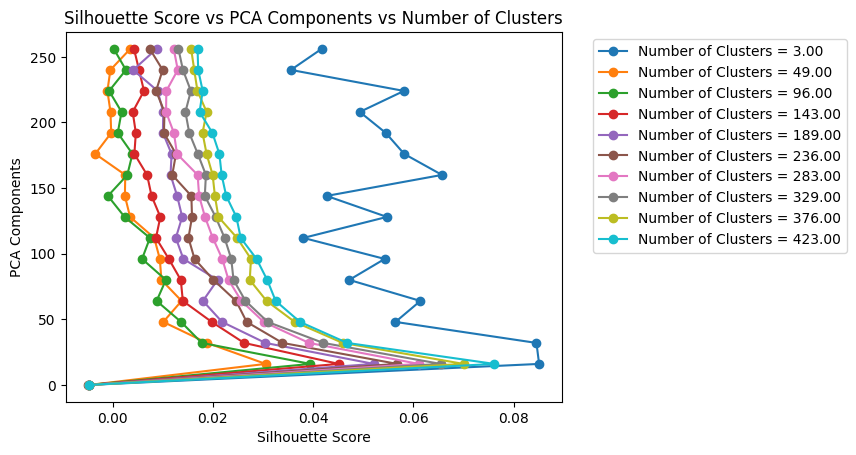

In [ ]:
for i in range(len(n_clusters)):
    plt.plot(losses[i], pca_range, label=f'Number of Clusters = {n_clusters[i]:.2f}', color=colors[i], marker='o')

# Add labels and legend
plt.xlabel('Silhouette Score')
plt.ylabel('PCA Components')
plt.title('Silhouette Score vs PCA Components vs Number of Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

plt.show()

### 4. Gaussian Mixture Model


---

GMM's are good for density estimation.

In [ ]:
losses = []
if len(n_clusters) == 0:
  n_clusters = [int(i) for i in np.linspace(3, num_clusters, num=10)]


for j in n_clusters:
  gmm = GaussianMixture(n_components=j, covariance_type='full')
  temp_loss = []
  for i in pca_range:
    if i == 0:
      df_avg['cluster'] = kmeans.fit_predict(df_avg['synopsis_embeddings'].tolist())

    else:
      pca = PCA(n_components=i)
      pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
      # Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
      pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

      # Create a list of tensors, each with shape (1, 64)
      pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

      # Create a new column in the DataFrame and assign the list of tensors
      df_avg['pca_embeddings'] = [i for i in pca_embedd]

      df_avg['cluster'] = gmm.fit_predict(df_avg['pca_embeddings'].tolist())

    temp_loss = temp_loss + [silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]

  losses.append(temp_loss)



print(len(losses), losses[0], "\n", len(pca_range), pca_range[0], "\n", len(n_clusters), n_clusters[0])

data = {'Number of Clusters': n_clusters, 'PCA Components': pca_range, 'Silhouette Loss': losses}

10 [-0.004833081159554752, 0.10880220625397383, 0.07793068934958518, 0.06892468675660615, 0.06491529307122222, 0.06348929084403261, 0.07071333697974629, 0.07056705954580313, 0.06904809602656746, 0.07029976675715784, 0.06971972999350101, 0.0685028996238859, 0.06747580584253683, 0.06660119001213731, 0.0654440103511325, 0.06552340003070636, 0.06479875503538676] 
 17 0 
 10 3


In [ ]:
colors = cm.tab10(np.linspace(0, 1, len(n_clusters)))

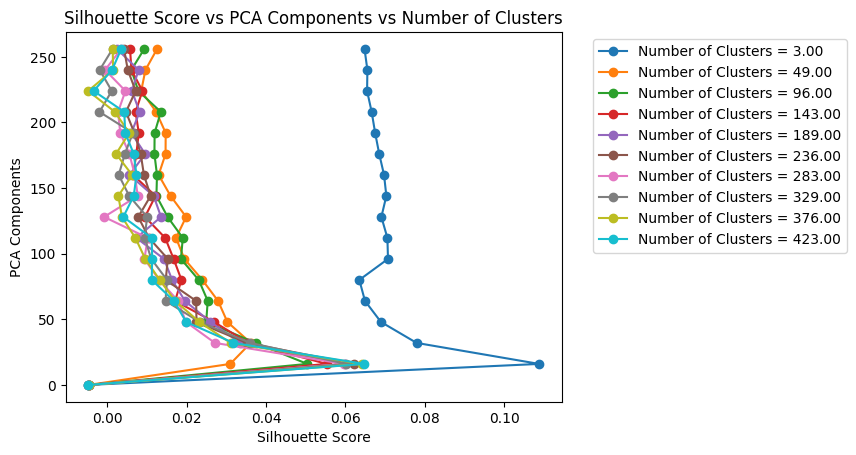

In [ ]:
for i in range(len(n_clusters)):
    plt.plot(losses[i], pca_range, label=f'Number of Clusters = {n_clusters[i]:.2f}', color=colors[i], marker='o')

# Add labels and legend
plt.xlabel('Silhouette Score')
plt.ylabel('PCA Components')
plt.title('Silhouette Score vs PCA Components vs Number of Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

plt.show()

## Davies-Bouldin Score


The Davies-Bouldin Index is a validation metric that is used to evaluate clustering models. It is calculated as the average similarity measure of each cluster with the cluster most similar to it. In this context, similarity is defined as the ratio between inter-cluster and intra-cluster distances. As such, this index ranks well-separated clusters with less dispersion as having a better score.

For a dataset $ X = X1, X2, X3, ......$ the Davies-Bouldin Index for $k$ number of clusters can be calculated as:

$
DB = \frac{1}{k} \sum_{i = 1}^{k} max(\frac{\Delta X_i + \Delta X_j}{\delta (X_i, X_j)})
$

where:
* $\Delta X_k$
  is the intracluster distance within the cluster $X_k$.
* $\delta(X_i, X_j)$
is the intercluster distance between the clusters $X_i$ and $X_j$.


The Davies-Bouldin index is very effective compared to other clustering evaluation metrics because:

- It is flexible and works for any number of clusters.
- It makes no assumptions about the shape of the clusters, unlike Silhouette - - Score evaluation metric.
- It is easy to use and intuitive.


---

Source: [GeeksForGeeks](https://www.geeksforgeeks.org/davies-bouldin-index/)

### 1. Affinity Propagation


---

This style of model was chosen for its usecase properties. This model also helps in generating a good estimate of number of clusters for other models.

In [ ]:
affP = AffinityPropagation()
losses = []
n_clusters = []

for i in pca_range:
  if i == 0:
    df_avg['cluster'] = affP.fit_predict(df_avg['synopsis_embeddings'].tolist())

  else:
    pca = PCA(n_components=i)
    pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
    pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)
    pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]
    df_avg['pca_embeddings'] = [i for i in pca_embedd]
    df_avg['cluster'] = affP.fit_predict(df_avg['pca_embeddings'].tolist())

  losses = losses + [davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]
  n_clusters = n_clusters + [len(affP.cluster_centers_)]


data = {'Davies-Bouldin Score': losses, 'PCA Components': pca_range, 'Number of Clusters': n_clusters}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


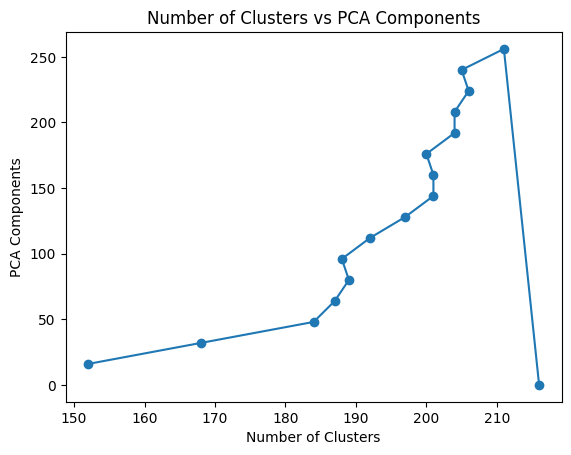

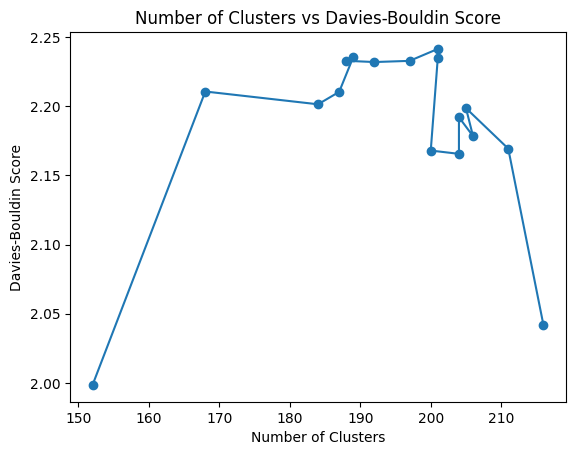

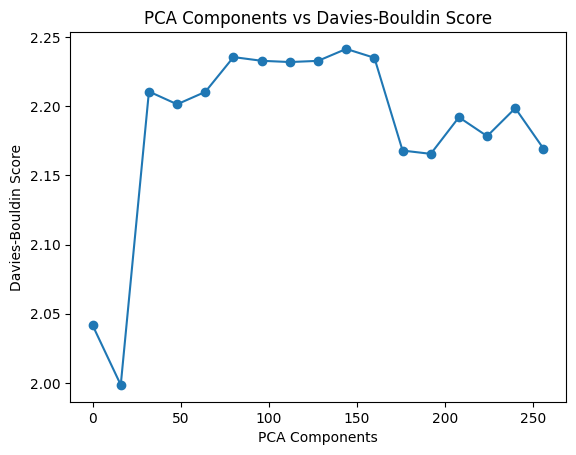

In [ ]:
# plt.subplot(1, 3, 1)
plt.plot(data['Number of Clusters'][1:] + [data['Number of Clusters'][0]], data['PCA Components'][1:] + [data['PCA Components'][0]], marker='o')
plt.title('Number of Clusters vs PCA Components')
plt.xlabel('Number of Clusters')
plt.ylabel('PCA Components')
plt.show()

# plt.subplot(1, 3, 2)
plt.plot(data['Number of Clusters'][1:] + [data['Number of Clusters'][0]], data['Davies-Bouldin Score'][1:] + [data['Davies-Bouldin Score'][0]], marker='o')
plt.title('Number of Clusters vs Davies-Bouldin Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.show()

# plt.subplot(1, 3, 3)
plt.plot(data['PCA Components'], data['Davies-Bouldin Score'], marker='o')
plt.title('PCA Components vs Davies-Bouldin Score')
plt.xlabel('PCA Components')
plt.ylabel('Davies-Bouldin Score')
plt.show()

### 2. KMeans


---

Kmeans was chosen as it is useful for multiple use cases and provides a baseline performance to measure other algorithms.

In [ ]:
losses = []
if len(n_clusters) == 0:
  n_clusters = [int(i) for i in np.linspace(3, num_clusters, num=10)]


for j in n_clusters:
  kmeans = KMeans(n_clusters=j, random_state=42)
  temp_loss = []
  for i in pca_range:
    if i == 0:
      df_avg['cluster'] = kmeans.fit_predict(df_avg['synopsis_embeddings'].tolist())

    else:
      pca = PCA(n_components=i)
      pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
      # Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
      pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

      # Create a list of tensors, each with shape (1, 64)
      pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

      # Create a new column in the DataFrame and assign the list of tensors
      df_avg['pca_embeddings'] = [i for i in pca_embedd]

      df_avg['cluster'] = kmeans.fit_predict(df_avg['pca_embeddings'].tolist())

    temp_loss = temp_loss + [davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]

  losses.append(temp_loss)



print(len(losses), losses[0], "\n", len(pca_range), pca_range[0], "\n", len(n_clusters), n_clusters[0])

data = {'Number of Clusters': n_clusters, 'PCA Components': pca_range, 'Silhouette Loss': losses}

10 [3.4142751111541085, 2.3174025497062147, 2.707484177298015, 2.878426670566577, 3.0080926184427867, 3.0898572073496897, 3.1574412705614034, 3.19460233488674, 3.2451094037242374, 3.278993847198843, 3.3053775543370207, 3.337455979425045, 3.357139397636368, 3.3763156603792392, 3.3908856926903463, 3.4046976282288983, 3.4169716173901077] 
 17 0 
 10 3


In [ ]:
colors = cm.tab10(np.linspace(0, 1, len(n_clusters)))
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]])

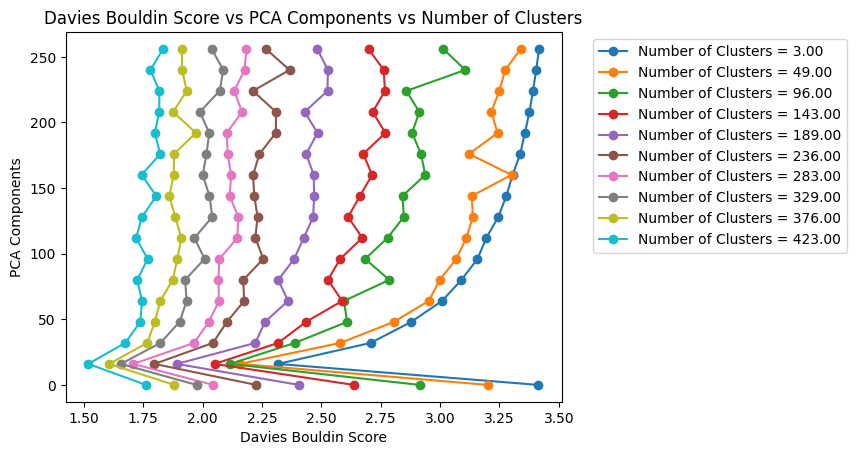

In [ ]:
for i in range(len(n_clusters)):
    plt.plot(losses[i], pca_range, label=f'Number of Clusters = {n_clusters[i]:.2f}', color=colors[i], marker='o')

# Add labels and legend
plt.xlabel('Davies Bouldin Score')
plt.ylabel('PCA Components')
plt.title('Davies Bouldin Score vs PCA Components vs Number of Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

plt.show()

### 3. Agglomerative Clustering with Ward Linkage


---

Supports both large number of samples with large number of clusters.

In [ ]:
losses = []
if len(n_clusters) == 0:
  n_clusters = [int(i) for i in np.linspace(3, num_clusters, num=10)]


for j in n_clusters:
  agg_w = AgglomerativeClustering(n_clusters=j, linkage='ward')
  temp_loss = []
  for i in pca_range:
    if i == 0:
      df_avg['cluster'] = kmeans.fit_predict(df_avg['synopsis_embeddings'].tolist())

    else:
      pca = PCA(n_components=i)
      pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
      # Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
      pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

      # Create a list of tensors, each with shape (1, 64)
      pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

      # Create a new column in the DataFrame and assign the list of tensors
      df_avg['pca_embeddings'] = [i for i in pca_embedd]

      df_avg['cluster'] = agg_w.fit_predict(df_avg['pca_embeddings'].tolist())

    temp_loss = temp_loss + [davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]

  losses.append(temp_loss)



print(len(losses), losses[0], "\n", len(pca_range), pca_range[0], "\n", len(n_clusters), n_clusters[0])

data = {'Number of Clusters': n_clusters, 'PCA Components': pca_range, 'Silhouette Loss': losses}

10 [1.7624396592200278, 2.3669904195651035, 3.386960978684613, 3.431661475001667, 3.6956956024705185, 4.203512045143275, 3.5418260380283724, 3.564413147147255, 3.758733400061864, 4.045370668590447, 3.9732997339462286, 3.3773605828355056, 3.644118275234659, 3.7467102995457595, 3.9520158308217876, 3.4936388736804957, 4.132534410933231] 
 17 0 
 10 3


In [ ]:
color = cm.tab10(np.linspace(0, 1, len(n_clusters)))

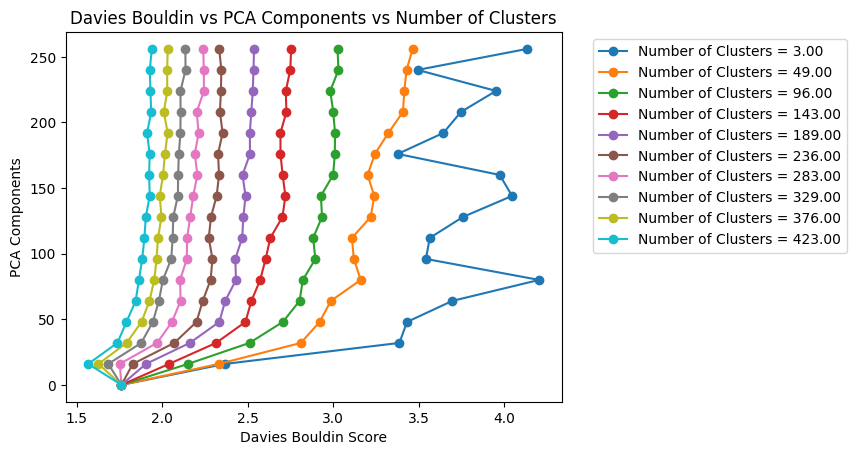

In [ ]:
for i in range(len(n_clusters)):
    plt.plot(losses[i], pca_range, label=f'Number of Clusters = {n_clusters[i]:.2f}', color=colors[i], marker='o')

# Add labels and legend
plt.xlabel('Davies Bouldin Score')
plt.ylabel('PCA Components')
plt.title('Davies Bouldin vs PCA Components vs Number of Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

plt.show()

### 4. Gaussian Mixture Model


---

GMM's are good for density estimation.

In [ ]:
losses = []
if len(n_clusters) == 0:
  n_clusters = [int(i) for i in np.linspace(3, num_clusters, num=10)]


for j in n_clusters:
  gmm = GaussianMixture(n_components=j, covariance_type='full')
  temp_loss = []
  for i in pca_range:
    if i == 0:
      df_avg['cluster'] = kmeans.fit_predict(df_avg['synopsis_embeddings'].tolist())

    else:
      pca = PCA(n_components=i)
      pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
      # Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
      pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

      # Create a list of tensors, each with shape (1, 64)
      pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

      # Create a new column in the DataFrame and assign the list of tensors
      df_avg['pca_embeddings'] = [i for i in pca_embedd]

      df_avg['cluster'] = gmm.fit_predict(df_avg['pca_embeddings'].tolist())

    temp_loss = temp_loss + [davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]

  losses.append(temp_loss)



print(len(losses), losses[0], "\n", len(pca_range), pca_range[0], "\n", len(n_clusters), n_clusters[0])

data = {'Number of Clusters': n_clusters, 'PCA Components': pca_range, 'Silhouette Loss': losses}

10 [1.7625199657413093, 2.736368236025612, 3.183771076408712, 3.3608946452562045, 3.480574240935136, 3.256810205661013, 3.2568443960057665, 3.2986490716345, 3.3074179264932684, 3.35809646534654, 3.390754837723641, 3.3934356851846754, 3.4337944165335337, 3.4202295553069013, 3.4076263853038586, 3.4300042692312154, 3.422848087695511] 
 17 0 
 10 3


In [ ]:
colors = cm.tab10(np.linspace(0, 1, len(n_clusters)))

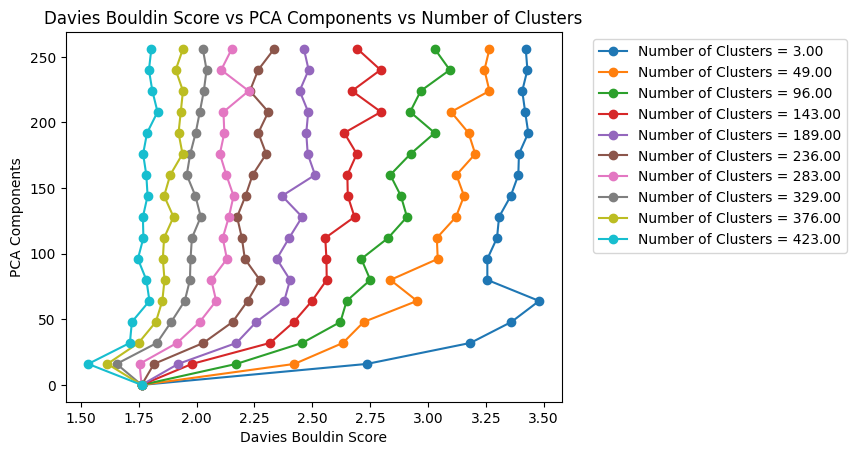

In [ ]:
for i in range(len(n_clusters)):
    plt.plot(losses[i], pca_range, label=f'Number of Clusters = {n_clusters[i]:.2f}', color=colors[i], marker='o')

# Add labels and legend
plt.xlabel('Davies Bouldin Score')
plt.ylabel('PCA Components')
plt.title('Davies Bouldin Score vs PCA Components vs Number of Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

plt.show()

# Hyper Parameter Tuning

## 1. Number of Features

Finding the Best PCA number of components for fixed cluster size on given models. The fixed number of clusters / components are taken to be 18 as thier are 18 distinct genre tags available in the dataset. Generally, the models perfom best with **3** features and increasing number of cluster / component size.

In [ ]:
# Models
ap = AffinityPropagation()
kmeans = KMeans(n_clusters=18, random_state=42)
agg_w = AgglomerativeClustering(n_clusters=18, linkage='ward')
gmm = GaussianMixture(n_components=18, covariance_type='full')

model_d = {
    0: ap,
    1: kmeans,
    2: agg_w,
    3: gmm
}

In [ ]:
n = 768 # Length of each BERT embedding

pca_range = [i for i in np.linspace(3, n, num=100, dtype=int)]

In [ ]:
silhouette_loss = [[0] for i in range(4)]
davies_bouldin_loss = [[0] for i in range(4)]
affinity_prop_cluster = []

for i in pca_range:
      pca = PCA(n_components=i)
      pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
      # Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
      pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

      # Create a list of tensors, each with shape (1, 64)
      pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

      # Create a new column in the DataFrame and assign the list of tensors
      df_avg['pca_embeddings'] = [i for i in pca_embedd]

      # Recording Metrics for all models at current number of features
      for i in model_d.keys():
        df_avg['cluster'] = model_d[i].fit_predict(df_avg['pca_embeddings'].tolist())
        if i == 0: affinity_prop_cluster = affinity_prop_cluster + [len(ap.cluster_centers_)]
        silhouette_loss[i] = silhouette_loss[i] + [silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]
        davies_bouldin_loss[i] = davies_bouldin_loss[i] + [davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])]

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Af

In [ ]:
silhouette_loss = [i[1:] for i in silhouette_loss]
davies_bouldin_loss = [i[1:] for i in davies_bouldin_loss]

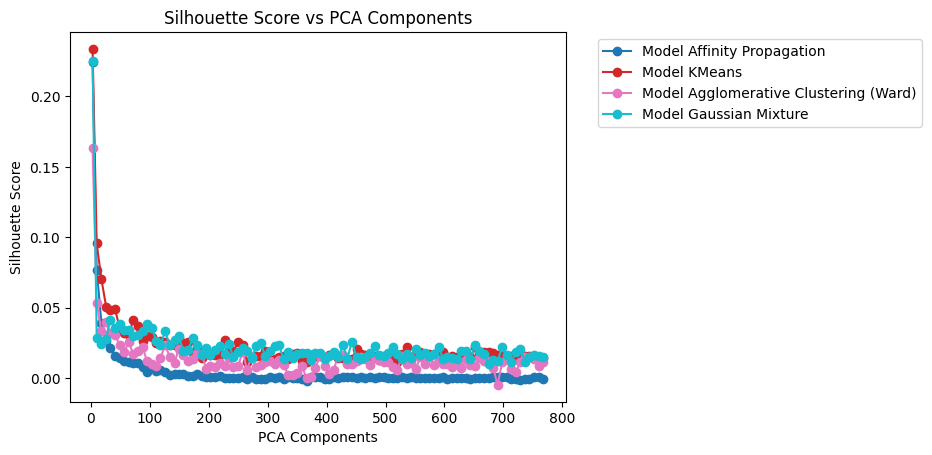

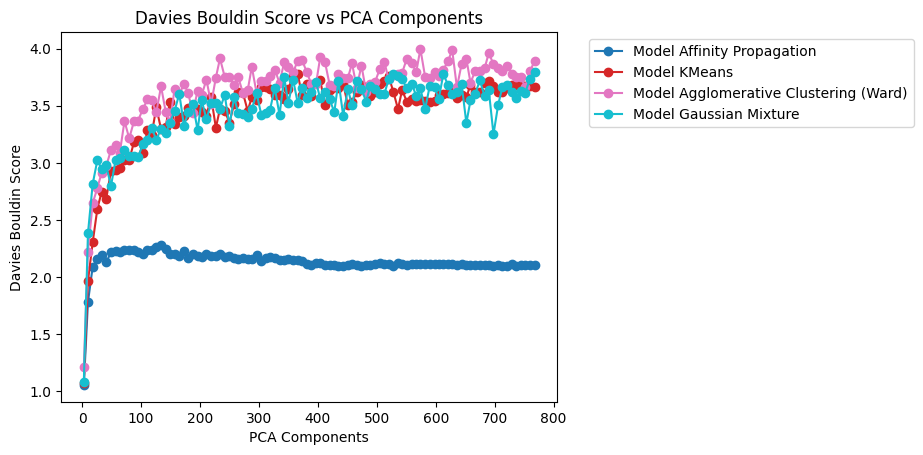

In [ ]:
# Plotting Loss metrics
colors = cm.tab10(np.linspace(0, 1, 4))
model_name = ['Affinity Propagation', 'KMeans', 'Agglomerative Clustering (Ward)', 'Gaussian Mixture']

# Silhouette Score VS PCA
for i in model_d.keys():
  plt.plot(pca_range, silhouette_loss[i], label=f'Model {model_name[i]}', color=colors[i], marker='o')
  plt.xlabel('PCA Components')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Score vs PCA Components')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

plt.show()


# Davies Bouldin Score VS PCA
for i in model_d.keys():
  plt.plot(pca_range, davies_bouldin_loss[i], label=f'Model {model_name[i]}', color=colors[i], marker='o')
  plt.xlabel('PCA Components')
  plt.ylabel('Davies Bouldin Score')
  plt.title('Davies Bouldin Score vs PCA Components')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

plt.show()

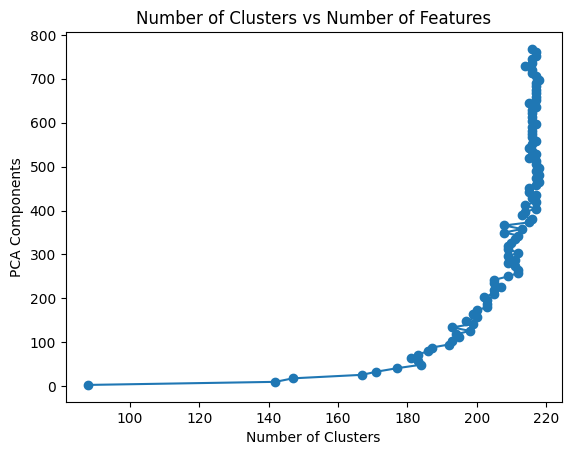

In [ ]:
# Number of Clusters VS Number of Features as per Affinity Propagation Model
plt.plot(affinity_prop_cluster, pca_range, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('PCA Components')
plt.title('Number of Clusters vs Number of Features')
plt.show()

## 2. Number of Cluster / Components

According to various graphs for the models with varying parameters (**NOTE**: Silhouette score near to 1 is better while Davies Bouldin score near to 0 is preferred):

* **Afiinity Propagation** Performs best (based on Silouette and Davies Bouldin score) at for **3 features**.

* **KMeans** performs best with **3** features and nearly **423** clusters.

* **Agglomerative Clustering** performs best with **3** features and **423** clusters.

* **Gaussian Mixture** model perfomrs best with **3** features and **423** components.

In [ ]:
# For Affinity Propagation
ap = AffinityPropagation()

pca = PCA(n_components=3)
pca_embedd = pca.fit_transform(df_avg['synopsis_embeddings'].tolist())
# Reshape pca_embedd to (num_samples, 1, 64) and convert to tensor
pca_embedd_tensor = torch.tensor(pca_embedd).unsqueeze(1)

# Create a list of tensors, each with shape (1, 64)
pca_embeddings_list = [pca_embedd_tensor[i] for i in range(pca_embedd_tensor.shape[0])]

# Create a new column in the DataFrame and assign the list of tensors
df_avg['pca_embeddings'] = [i for i in pca_embedd]

df_avg['cluster'] = ap.fit_predict(df_avg['pca_embeddings'].tolist())

print(f"Number of Selected features: {3} \nNumber of Clusters: {len(ap.cluster_centers_)} \nSilhouette Score: {silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])} \nDavies Bouldin Score: {davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])}")

Number of Selected features: 3 
Number of Clusters: 87 
Silhouette Score: 0.22066413903641394 
Davies Bouldin Score: 1.0432482481763137


In [ ]:
factor = 5.3824
n_clusters = [i for i in np.linspace(3, 423, num=10, dtype=int)] + [i for i in np.linspace(423, 2687, num=int(10*factor), dtype=int)]

silhouette_loss = [[0] for i in range(3)]
davies_bouldin_loss = [[0] for i in range(3)]

for i in n_clusters:
  kmeans = KMeans(n_clusters=i, random_state=42)
  agg_w = AgglomerativeClustering(n_clusters=i, linkage='ward')
  gmm = GaussianMixture(n_components=i, covariance_type='full')

  # Kmeans
  silhouette_loss[0] = silhouette_loss[0] + [silhouette_score(df_avg['pca_embeddings'].tolist(), kmeans.fit_predict(df_avg['pca_embeddings'].tolist()))]
  davies_bouldin_loss[0] = davies_bouldin_loss[0] + [davies_bouldin_score(df_avg['pca_embeddings'].tolist(), kmeans.fit_predict(df_avg['pca_embeddings'].tolist()))]

  # Agglomerative Clustering
  silhouette_loss[1] = silhouette_loss[1] + [silhouette_score(df_avg['pca_embeddings'].tolist(), agg_w.fit_predict(df_avg['pca_embeddings'].tolist()))]
  davies_bouldin_loss[1] = davies_bouldin_loss[1] + [davies_bouldin_score(df_avg['pca_embeddings'].tolist(), agg_w.fit_predict(df_avg['pca_embeddings'].tolist()))]

  # Gaussian Mixture Model
  silhouette_loss[2] = silhouette_loss[2] + [silhouette_score(df_avg['pca_embeddings'].tolist(), gmm.fit_predict(df_avg['pca_embeddings'].tolist()))]
  davies_bouldin_loss[2] = davies_bouldin_loss[2] + [davies_bouldin_score(df_avg['pca_embeddings'].tolist(), gmm.fit_predict(df_avg['pca_embeddings'].tolist()))]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2683) found smaller than n_clusters (2687). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2683) found smaller than n_clusters (2687). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2683) found smaller than n_clusters (2687). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2683) found smaller than n_clusters (2687). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
silhouette_loss = [i[1:] for i in silhouette_loss]
davies_bouldin_loss = [i[1:] for i in davies_bouldin_loss]

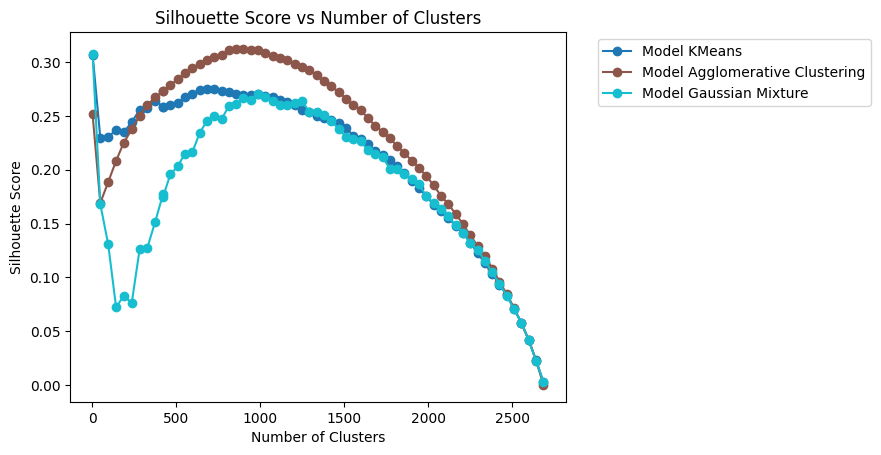

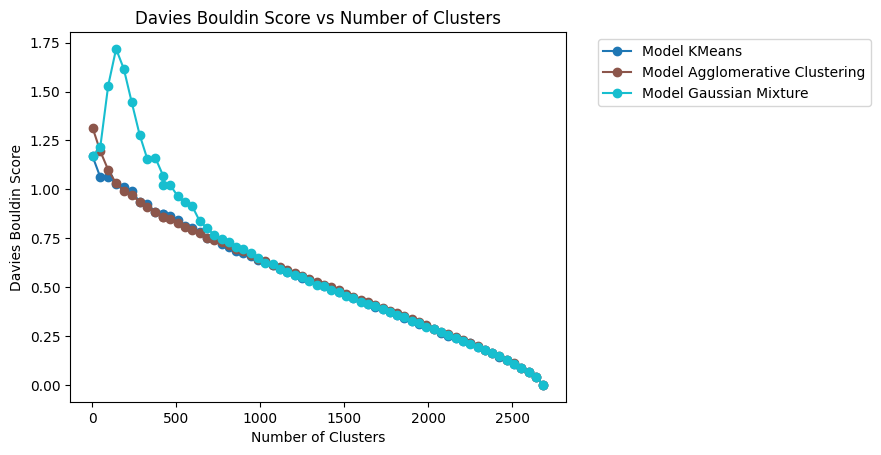

In [ ]:
# Plotting THe Values
# Silhoueete score

model_name = ['KMeans', 'Agglomerative Clustering', 'Gaussian Mixture']
colors = cm.tab10(np.linspace(0, 1, 3))

for i in range(3):
  plt.plot(n_clusters, silhouette_loss[i],label=f'Model {model_name[i]}', color=colors[i], marker='o')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Score vs Number of Clusters')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.show()


for i in range(3):
  plt.plot(n_clusters, davies_bouldin_loss[i],label=f'Model {model_name[i]}', color=colors[i], marker='o')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Davies Bouldin Score')
  plt.title('Davies Bouldin Score vs Number of Clusters')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.show()

In [ ]:
for i in range(3):
  a = np.argmax(silhouette_loss[i])
  print(f"For model {model_name[i]} : Clusters: {n_clusters[a]} - Silhouette Score: {silhouette_loss[i][a]} || Davies-Boulin Score: {davies_bouldin_loss[i][a]}")

For model KMeans : Clusters: 3 - Silhouette Score: 0.30707533503582124 || Davies-Boulin Score: 1.168728660165156
For model Agglomerative Clustering : Clusters: 901 - Silhouette Score: 0.31233377139424795 || Davies-Boulin Score: 0.6823371172092239
For model Gaussian Mixture : Clusters: 3 - Silhouette Score: 0.3078791491633459 || Davies-Boulin Score: 1.1679644383455392


## 3. Finding Best Hyper Parameters

- **Affinity Propagation**: `damping` and `affinity`
- **Agglomerative Clustering**: `linkage` and `distance`
- **Gaussian Mixture**: `covariance type` and `init_params`

In [ ]:
# Make Custom Scorer
def silhouette_Davies_Bouldin(y_true, y_pred):
  return davies_bouldin_score(y_true, y_pred) - silhouette_score(y_true, y_pred) + 1

customScorer = make_scorer(silhouette_Davies_Bouldin, greater_is_better=True)

#### 3.1 Affinity Propagation

In [ ]:
# Parameter List
params = {
    'damping': np.linspace(0.5, 1.0, num=10),
    'affinity': ['euclidean']
}


# Model
afp = AffinityPropagation(random_state=37)

grid_afp = GridSearchCV(estimator=afp, param_grid=params, scoring=customScorer)
grid_afp.fit(df_avg['pca_embeddings'].tolist(), df_avg['pca_embeddings'].tolist())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_pa

GridSearchCV(estimator=AffinityPropagation(random_state=37),
             param_grid={'affinity': ['euclidean'],
                         'damping': array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ])},
             scoring=make_scorer(silhouette_Davies_Bouldin, response_method='predict'))

In [ ]:
grid_afp.best_params_

{'affinity': 'euclidean', 'damping': 0.8333333333333333}

In [ ]:
afp = AffinityPropagation(damping=0.8333, affinity='euclidean')
df_avg['cluster'] = afp.fit_predict(df_avg['pca_embeddings'].tolist())

print(f"Number of Selected features: {3} \nNumber of Clusters: {len(afp.cluster_centers_)} \nSilhouette Score: {silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])} \nDavies Bouldin Score: {davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])}")

Number of Selected features: 3 
Number of Clusters: 84 
Silhouette Score: 0.2318449508621439 
Davies Bouldin Score: 1.0376335963413799


#### 3.2 Agglomerative Clustering

In [ ]:
# Parameters
params = {
    'linkage': ['complete', 'average', 'single'],
    'metric':['l1', 'l2', 'euclidean', 'cosine', 'manhattan']
}

# Model
agg_w = AgglomerativeClustering(n_clusters=901)

grid_agg_w = GridSearchCV(estimator=agg_w, param_grid=params, scoring=customScorer, refit=True)
grid_agg_w.fit(df_avg['pca_embeddings'].tolist(), df_avg['pca_embeddings'].tolist())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  F

GridSearchCV(estimator=AgglomerativeClustering(n_clusters=901),
             param_grid={'linkage': ['complete', 'average', 'single'],
                         'metric': ['l1', 'l2', 'euclidean', 'cosine',
                                    'manhattan']},
             scoring=make_scorer(silhouette_Davies_Bouldin, response_method='predict'))

In [ ]:
grid_agg_w.best_params_

{'linkage': 'complete', 'metric': 'l1'}

In [ ]:
test = grid_agg_w.best_estimator_
df_avg['cluster'] = test.fit_predict(df_avg['pca_embeddings'].tolist())

print(f"Number of Selected features: {3} \nSilhouette Score: {silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])} \nDavies Bouldin Score: {davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])}")

Number of Selected features: 3 
Silhouette Score: 0.27019873231893327 
Davies Bouldin Score: 0.7271581514569526


In [ ]:
ward = AgglomerativeClustering(n_clusters=901, linkage='ward')
df_avg['cluster'] = ward.fit_predict(df_avg['pca_embeddings'].tolist())

print(f"Number of Selected features: {3} \nSilhouette Score: {silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])} \nDavies Bouldin Score: {davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])}")

Number of Selected features: 3 
Silhouette Score: 0.31233377139424795 
Davies Bouldin Score: 0.6823371172092239


### 3.3 Gaussian Mixture model

In [ ]:
# Parameters
params = {
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'random']
}
gmm = GaussianMixture(n_components=3)

grid_gmm = GridSearchCV(estimator=gmm, param_grid=params, scoring=customScorer)
grid_gmm.fit(df_avg['pca_embeddings'].tolist(), df_avg['pca_embeddings'].tolist())

GridSearchCV(estimator=GaussianMixture(n_components=3),
             param_grid={'covariance_type': ['full', 'tied', 'diag',
                                             'spherical'],
                         'init_params': ['kmeans', 'random']},
             scoring=make_scorer(silhouette_Davies_Bouldin, response_method='predict'))

In [ ]:
grid_gmm.best_params_

{'covariance_type': 'full', 'init_params': 'random'}

In [ ]:
grid_gmm.best_score_

3.1210782774475296

In [ ]:
test = grid_gmm.best_estimator_
df_avg['cluster'] = test.fit_predict(df_avg['pca_embeddings'].tolist())

print(f"Number of Selected features: {3} \nSilhouette Score: {silhouette_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])} \nDavies Bouldin Score: {davies_bouldin_score(df_avg['pca_embeddings'].tolist(), df_avg['cluster'])}")

Number of Selected features: 3 
Silhouette Score: 0.18365021811423896 
Davies Bouldin Score: 1.769587274806388


## 4 Save Clustered adataset

Save the dataset clustering done by the best model as `clustered_recom.pkl`

In [ ]:
# @title Save Clustered Dataset File {"vertical-output":true,"display-mode":"form"}
# @markdown Do you want to save the above generated Dataframe?
save_choice = "Yes" # @param ["Yes","No"]


In [ ]:
# @title Save options {"vertical-output":true,"display-mode":"form"}
# @markdown Select a save Option:
opt = "Connect to google drive and save" # @param ["Connect to google drive and save to custom path","Connect to google drive and save","Save to runtime memory"]


opt_d = {
    "Connect to google drive and save to custom path": 0,
    "Connect to google drive and save": 1,
    "Save to runtime memory": 2
}

In [ ]:
filename = "clustered_recom.pkl"
if save_choice == "Yes" and opt_d[opt] == 0 :
  path = input("Enter Custom (complete) Path: ")
  try: pd.to_pickle(df_avg, f'{path}/{filename}')
  except: print("df_avg dataframe Dosen't Exist! Try: \n 1. Make sure you're google drive is connected to the runtime and the save path exists.\n 2. Re-run above cells to generate the processed dataframe\n 3.Disconnecting and then reconnecting to a runtime and running above cells\n 4. Loading a previously saved Dataframe from below given cells")

elif save_choice == "Yes" and opt_d[opt] == 1 :
  try: pd.to_pickle(df_avg, f'/content/drive/MyDrive/Manhwa Data/{filename}')
  except: print("df_avg dataframe Dosen't Exist! Try: \n 1. Make sure you're google drive is connected to the runtime and the save path exists.\n 2. Re-run above cells to generate the processed dataframe\n 3.Disconnecting and then reconnecting to a runtime and running above cells\n 4. Loading a previously saved Dataframe from below given cells")

elif save_choice == "Yes" and opt_d[opt] == 2:
  pd.to_pickle(df_avg, f'/content/{filename}')

# Recommender

**NOTE:** Connect to google drive or upload the file before proceeding. To connect the google drive, use the cells in Dataset section.

---

**Based on:**
Best Model Performance

- **Agglomerative Clustering**:
  - **Ward** linkage with **901** clusters
  - *Silhouette Score*: `0.31233377139424795`
  - *Davies-Bouldin Score*: `0.6823371172092239`

- PCA components: 3


---

Data Clustered and saved to `clustered_recom.pkl`

## Load Clustered Dataset

In [ ]:
# @title Load Pickle File {"display-mode":"form"}
# @markdown Do you want to load a Dataframe?
load_choice = "Yes" # @param ["Yes","No"]


In [ ]:
# @title Load Parameters {"vertical-output":true,"display-mode":"form"}
# @markdown Path to `clustered_recom.pkl` file
path = "/content/drive/MyDrive/Manhwa Data" # @param {"type":"string","placeholder":"/absolute/path/to/file"}
filename = 'clustered_recom.pkl'

In [ ]:
if load_choice == "Yes":
  try: df_avg = pd.read_pickle(f'{path}/{filename}')
  except: print(f"{filename} dataframe Dosen't Exist! Try: \n 1. Make sure you're google drive is connected to the runtime and the load path exists.\n 2. Check if the dataset exists in drive/path\n 3.Disconnecting and then reconnecting to a runtime and running above cells")

## Recommender

In [63]:
from google.colab import output
import ipywidgets as widgets
from IPython.display import display

# List of possible inputs
options = [i for i in df_avg['title'].unique()]

# Text input for filtering
filter_input = widgets.Text(placeholder="Type to filter options")

# Dropdown for filtered options
filtered_dropdown = widgets.Dropdown(options=options, description="Select:")

def update_dropdown(change):
    search_term = change['new'].lower()
    filtered_options = [opt for opt in options if search_term in opt.lower()]
    filtered_dropdown.options = filtered_options if filtered_options else ["No match found"]

# Attach the function to filter input
filter_input.observe(update_dropdown, names='value')

# Display widgets
display(filter_input, filtered_dropdown)

Text(value='', placeholder='Type to filter options')

Dropdown(description='Select:', options=('Solo Leveling', 'The Horizon', 'Wind Breaker', 'Bastard', 'Who Made …

In [72]:
name = filtered_dropdown.value
try:
  cluster_val = df_avg[df_avg['title'] == name]['cluster']
  print(cluster_val)
except:
  print("Title dosent exist in the database!")

df_avg[df_avg['cluster'] == cluster_val.iloc[0]][:10]

4    337
Name: cluster, dtype: int64


,title,synopsis_embeddings,pca_embeddings,cluster
4,Who Made Me a Princess,"[-0.31436124444007874, -0.09806779772043228, 0...","[1.2068851097178812, 1.3281786433409148, -0.92...",337
2926,On a Leash,"[-0.24152091145515442, -0.13565652072429657, 0...","[1.3346726117265357, 1.1032931954316316, -0.97...",337
